In [ ]:
# pip install esential libraries
!pip install torchtext==0.13.1 -q
!pip install pytorch-lightning==1.9.4 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.12.1 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 1.12.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 40.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import optuna
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score


In [ ]:
torch.cuda.empty_cache()

### Data Loading

In [ ]:
file_path = "/content/drive/MyDrive/semeval-dataset/"
train_fname = "eng_train.csv"
dev_fname = "eng_a_dev.csv"
# test_fname = "eng_b_test.csv  , not yet available

In [ ]:
if os.path.exists(file_path):
    train_df = pd.read_csv(file_path + train_fname)
    dev_df = pd.read_csv(file_path + dev_fname)
    # test_df = pd.read_csv(file_path + test_fname)
    print("All Data loaded successfully!")
else:
    print(f"Error: File not found at {file_path + '...'}")

All Data loaded successfully!


In [ ]:
train_df.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


In [ ]:
dev_df.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_dev_track_a_00001,"My mouth fell open `` No, no, no... I..",NaN,NaN,NaN,NaN,NaN
1,eng_dev_track_a_00002,You can barely make out your daughter's pale f...,NaN,NaN,NaN,NaN,NaN
2,eng_dev_track_a_00003,But after blinking my eyes for a few times lep...,NaN,NaN,NaN,NaN,NaN
3,eng_dev_track_a_00004,Slowly rising to my feet I came to the conclus...,NaN,NaN,NaN,NaN,NaN
4,eng_dev_track_a_00005,I noticed this months after moving in and doin...,NaN,NaN,NaN,NaN,NaN


Observation:

* Just 5 labels, `disgust` class is not included in this dataset

### Simple EDA

In [ ]:
train_df.text.values[1]

"Well she's not gon na last the whole song like that, so since I'm behind her and the audience can't see below my torso pretty much, I use my hand to push down on the lid and support her weight."

In [ ]:
labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [ ]:
# distribution of the labels in the training set
for label in labels:
    print(train_df[label].value_counts(normalize= True))

Anger
0    0.879697
1    0.120303
Name: proportion, dtype: float64
Fear
1    0.582009
0    0.417991
Name: proportion, dtype: float64
Joy
0    0.756503
1    0.243497
Name: proportion, dtype: float64
Sadness
0    0.682803
1    0.317197
Name: proportion, dtype: float64
Surprise
0    0.696893
1    0.303107
Name: proportion, dtype: float64


In [ ]:
train_df.shape

(2768, 7)

In [ ]:
# distribution of the labels in the validation set
for label in labels:
    print(dev_df[label].value_counts(normalize= True))

Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)


Okay Okay, the validation labels are empty/ NAN :( . Anyways, we can create a temporary validation set from the training data and use the dev data as test set for submission.

In [ ]:
dev_df.shape

(116, 7)

### Text Preprocessing

In [ ]:
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
BATCH_SIZE = 32

tokenizer = get_tokenizer('basic_english')


In [ ]:
#special tokens
unk_token = '<unk>'
pad_token = '<pad>'

In [ ]:
# applying the tokenizer func to all the rows of data
%%time
text_tokens = train_df.text.map(tokenizer)

CPU times: user 42.2 ms, sys: 0 ns, total: 42.2 ms
Wall time: 45.6 ms


In [ ]:
vocab = build_vocab_from_iterator(
    text_tokens,
    specials=[unk_token, pad_token],
    max_tokens=VOCAB_SIZE
)

In [ ]:
# check
print("unknown token index:",vocab[unk_token])
print("pad token index:",vocab[pad_token])

unknown token index: 0
pad token index: 1


In [ ]:
vocab.set_default_index(vocab[unk_token])

In [ ]:
#check for unseen words
vocab['semeval']

0

In [ ]:
vocab['tiamiyu']

0

<Axes: ylabel='Frequency'>

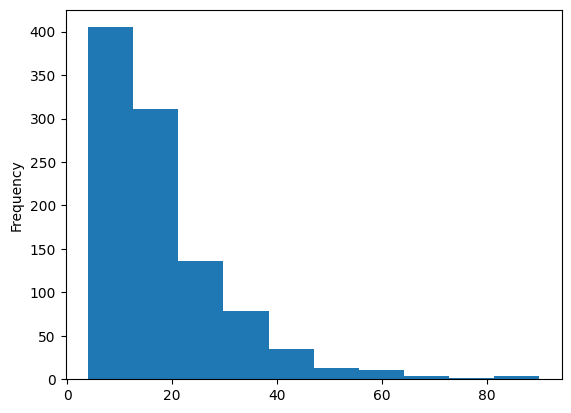

In [ ]:
train_df.text.sample(1000).map(tokenizer).map(len).plot.hist()

In [ ]:
MAX_LENGTH = 60

In [ ]:
def pad_tokens(tokens):
  if len(tokens) >= MAX_LENGTH:
    return tokens[:MAX_LENGTH]
  else:
    return tokens + [pad_token] * (MAX_LENGTH - len(tokens))

In [ ]:
# check check
train_df.text.values[0]


'But not very happy.'

In [ ]:
pad_tokens(tokenizer(train_df.text.values[0])) [:10]

['but',
 'not',
 'very',
 'happy',
 '.',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, df, is_dev= False):
    self.df = df
    self.is_dev = is_dev

  def __getitem__(self, index):
    comment_text = self.df.text.values[index]
    comment_tokens = tokenizer(comment_text)
    comment_tokens_padded = pad_tokens(comment_tokens)
    input = torch.tensor(vocab.lookup_indices(comment_tokens_padded))
    if self.is_dev:
      target  = torch.tensor([0,0,0,0,0]).float()
    else:
      target = torch.tensor(self.df[labels].values[index]).float()
    return input, target

  def __len__(self):
    return len(self.df)

In [ ]:
train_ds = EmotionDataset(train_df)

In [ ]:
train_ds[0]

(tensor([ 19,  39,  90, 375,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1]),
 tensor([0., 0., 1., 1., 0.]))

In [ ]:
frac = 0.25

In [ ]:
# train_ds, val_ds = random_split(raw_ds, [1-frac, frac])

train_size = int(len(train_ds) * (1 - frac)) # Calculate the length of the training set
val_size = len(train_ds) - train_size # Calculate the length of the validation set
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) # Split the dataset based on calculated lengths

In [ ]:
len(train_ds), len(val_ds)

(2076, 692)

In [ ]:
dev_ds = EmotionDataset(dev_df, is_dev=True)

In [ ]:
dev_ds[0]

(tensor([  3, 120, 171, 196,  80,  85,   5,  85,   5,  85,   2,   2,   2,   4,
           2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1]),
 tensor([0., 0., 0., 0., 0.]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
dev_dl = DataLoader(dev_ds)

In [ ]:
emb_layer = nn.Embedding(num_embeddings=VOCAB_SIZE,embedding_dim=256,padding_idx=1)

In [ ]:



class EmotionDetectionModel(pl.LightningModule):
    def __init__(self, lstm_hidden_size=128, model_type='lstm'):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, 256, 1)
        self.model_type = model_type
        if model_type == 'lstm':
            self.rnn = nn.LSTM(256, lstm_hidden_size, 1, batch_first=True)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(256, lstm_hidden_size, 1, batch_first=True, bidirectional=True)
            lstm_hidden_size = lstm_hidden_size * 2
        self.linear = nn.Linear(lstm_hidden_size, 5)
        self.learning_rate = 0.001

    def forward(self, x):
        out = self.emb(x)
        out, _ = self.rnn(out)
        out = F.relu(out[:, -1, :])
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = torch.sigmoid(outputs)
        loss = F.binary_cross_entropy(probs, targets)
        return {'loss': loss, 'probs': probs, 'targets': targets}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        all_probs = torch.cat([x['probs'] for x in outputs], dim=0).cpu().numpy()
        all_targets = torch.cat([x['targets'] for x in outputs], dim=0).cpu().numpy()

        best_macro_f1 = 0
        best_threshold = 0.0
        thresholds = np.arange(0.4, 1.0, 0.05)
        for threshold in thresholds:
            predictions = (all_probs > threshold).astype(int)
            macro_f1 = f1_score(all_targets, predictions, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_threshold = threshold


        self.log('val_loss', avg_loss, prog_bar=True)
        self.log('best_macro_f1', best_macro_f1, prog_bar=True)
        return {'loss': avg_loss, 'best_macro_f1': best_macro_f1, 'best_threshold': best_threshold}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)





In [ ]:
# trainer.tune(base_model, train_dl) # if you are using latest version of pl, dont run this code

In [ ]:
def objective(trial):
    lstm_hidden_size = trial.suggest_int('lstm_hidden_size', 64, 256)
    model_type = trial.suggest_categorical('model_type', ['lstm', 'bilstm'])

    model = EmotionDetectionModel(lstm_hidden_size=lstm_hidden_size, model_type=model_type)
    trainer = pl.Trainer(max_epochs=50, accelerator='cpu', auto_lr_find=False)
    trainer.fit(model, train_dl, val_dl)

    val_results = trainer.callback_metrics
    best_macro_f1 = val_results.get('best_macro_f1').item() if 'best_macro_f1' in val_results else 0.0
    return best_macro_f1


In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best trial
print(f"Best Trial: {study.best_trial.params}")

[I 2024-10-22 07:17:58,805] A new study created in memory with name: no-name-6b57c024-6022-4c9c-b079-48d23bc2f5ef
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 625 K 
2 | linear | Linear    | 1.8 K 
-------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.558     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 07:35:16,526] Trial 0 finished with value: 0.3769397246522506 and parameters: {'lstm_hidden_size': 179, 'model_type': 'bilstm'}. Best is trial 0 with value: 0.3769397246522506.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 567 K 
2 | linear | Linear    | 1.7 K 
-------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.326     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 07:51:43,726] Trial 1 finished with value: 0.38207565674996913 and parameters: {'lstm_hidden_size': 167, 'model_type': 'bilstm'}. Best is trial 1 with value: 0.38207565674996913.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 606 K 
2 | linear | Linear    | 1.8 K 
-------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.480     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 08:09:07,892] Trial 2 finished with value: 0.3546106574165785 and parameters: {'lstm_hidden_size': 175, 'model_type': 'bilstm'}. Best is trial 1 with value: 0.38207565674996913.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 167 K 
2 | linear | Linear    | 570   
-------------------------------------
680 K     Trainable params
0         Non-trainable params
680 K     Total params
2.721     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 08:17:39,646] Trial 3 finished with value: 0.3804858941199917 and parameters: {'lstm_hidden_size': 113, 'model_type': 'lstm'}. Best is trial 1 with value: 0.38207565674996913.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 118 K 
2 | linear | Linear    | 435   
-------------------------------------
630 K     Trainable params
0         Non-trainable params
630 K     Total params
2.523     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 08:25:13,215] Trial 4 finished with value: 0.3883660208953444 and parameters: {'lstm_hidden_size': 86, 'model_type': 'lstm'}. Best is trial 4 with value: 0.3883660208953444.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 238 K 
2 | linear | Linear    | 740   
-------------------------------------
750 K     Trainable params
0         Non-trainable params
750 K     Total params
3.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 08:34:38,482] Trial 5 finished with value: 0.36913189916509753 and parameters: {'lstm_hidden_size': 147, 'model_type': 'lstm'}. Best is trial 4 with value: 0.3883660208953444.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 415 K 
2 | linear | Linear    | 1.1 K 
-------------------------------------
928 K     Trainable params
0         Non-trainable params
928 K     Total params
3.713     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-10-22 08:47:07,638] Trial 6 finished with value: 0.3992784565417368 and parameters: {'lstm_hidden_size': 218, 'model_type': 'lstm'}. Best is trial 6 with value: 0.3992784565417368.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 512 K 
1 | rnn    | LSTM      | 956 K 
2 | linear | Linear    | 2.4 K 
-------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.882     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# dev_preds = trainer.predict(base_model, dev_dl)

In [ ]:
# dev_preds[:-10]

In [ ]:
# dev_preds = torch.cat(dev_preds)

In [ ]:
# dev_df.head()

In [ ]:
# preds_df = pd.DataFrame(dev_preds.numpy(), columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])

In [ ]:
# preds_df = preds_df[['Joy', 'Anger', 'Sadness', 'Surprise', 'Fear']]
# preds_df = preds_df.astype(int)

In [ ]:
# submission_df = pd.concat([dev_df['id'], preds_df], axis=1)

# submission_df.to_csv('pred_eng_a.csv', index=False)
# print(submission_df.head())

In [ ]:
# csv_filename = "pred_eng_a.csv"

In [ ]:
# zip_filename = 'pred_eng_a.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     zipf.write(csv_filename, arcname=os.path.basename(csv_filename))

# # Optional: remove the CSV file after zipping
# os.remove(csv_filename)

# # Check that the ZIP file has been created
# print(f"{zip_filename} created successfully!")